In [17]:
import numpy as np
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
from scipy.integrate import quad


In [2]:
# Paramètres des deux distributions bêta
alpha1, beta1 = 2, 5
alpha2, beta2 = 3, 4

# Création de l'échantillon des valeurs
x = np.linspace(0, 1, 1000)

# Calcul des PDF des deux distributions bêta
pdf1 = beta.pdf(x, alpha1, beta1)
pdf2 = beta.pdf(x, alpha2, beta2)

# Calcul de la probabilité de recouvrement
overlap_surface = np.minimum(pdf1, pdf2)
overlap_prob = np.trapz(np.minimum(pdf1, pdf2), x)

print("Probabilité de recouvrement entre les deux distributions bêta :", overlap_prob)


Probabilité de recouvrement entre les deux distributions bêta : 0.6707826352275587


Text(0.5, 1.0, 'overlap=0.67')

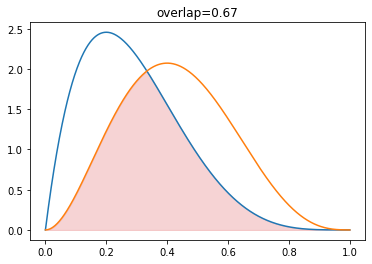

In [3]:
plt.plot(x, pdf1)
plt.plot(x, pdf2)
plt.fill_between(x, np.zeros_like(overlap_surface), overlap_surface, color='tab:red', alpha=.2)
plt.title(f'overlap={overlap_prob:.2f}')-(**)-Copy1

## Implication : A--> B (H1) et A --> non-B (H0)

In [6]:
def log_likelihood(q, x):
    # Calcul de la log-vraisemblance conditionnelle
    return x * np.log(q) + (1 - x) * np.log(1 - q)

In [83]:
h = 1
quad(lambda q: log_likelihood(q, h) * beta.pdf(q, 1, 1), 0, 1)

(-0.9999999999999999, 1.1102230246251563e-15)

In [84]:
log_likelihood(beta.mean(1,1), h)

-0.6931471805599453

In [85]:
def dirichlet_kl_divergence_monte_carlo(alpha, beta, num_samples=100000):
    dist_p = dirichlet(alpha)
    dist_q = dirichlet(beta)
    samples = dist_p.rvs(num_samples)
    kl_divergence = np.sum(np.log(dist_p.pdf(samples.T) / dist_q.pdf(samples.T))) / num_samples

    return kl_divergence

In [29]:
def simple_implication(data):
    plt.figure(figsize=(30,20))
    alpha_dict = {(0,0): 1, (0,1): 1, (1,0): 1, (1,1): 1}
    H0 = ((0,1), (1,1))
    #H0 = ((1,0)) #non : A --> B
    H1 = ((0,0), (0,1), (1,1)) # A --> nB
    beta_ = {'H0':[1,1], 'H1':[1,1]}
    log_lik_0 = 0
    log_lik_1 = 0
    for i, obs in enumerate(data):
        ax = plt.subplot(5,5,i+1)
        if obs in H0:
            beta_['H0'][0] += 1
            h0 = 1
        else:
            beta_['H0'][1] += 1
            h0 = 0
        if obs in H1:
            beta_['H1'][0] += 1
            h1 = 1
        else:
            beta_['H1'][1] += 1
            h1 = 0
        alpha_dict[obs] += 1
            
        pdf_H0 = beta.pdf(x, beta_['H0'][0], beta_['H0'][1])
        pdf_H1 = beta.pdf(x, beta_['H1'][0], beta_['H1'][1])
        
        ll, _ = quad(lambda q: log_likelihood(q, h0) * beta.pdf(q, beta_['H0'][0], beta_['H0'][1]), 0, 1) 
        log_lik_0 += ll
        KL_0, _ = quad(lambda q: beta.pdf(q, beta_['H0'][0], beta_['H0'][1]) * np.log(beta.pdf(q, beta_['H0'][0], beta_['H0'][1])/ beta.pdf(q, 1, 1)), 0, 1)
        FE_0 = - log_lik_0 + KL_0
        
        ll, _ = quad(lambda q: log_likelihood(q, h1) * beta.pdf(q, beta_['H1'][0], beta_['H1'][1]), 0, 1) 
        log_lik_1 += ll
        KL_1 = dirichlet_kl_divergence_monte_carlo(list(alpha_dict.values()), [1,1,1,1])
        FE_1 = - log_lik_1 + KL_1
        
        ax.plot(x, pdf_H0, label=r'H0: $B$'+f' ({FE_0:.2f})', color='tab:orange')
        ax.plot(x, pdf_H1, label=r'H1: $A \rightarrow B$'+f' ({FE_1:.2f})', color='tab:blue')
        overlap_surface = np.minimum(pdf_H0, pdf_H1)
        overlap_prob = np.trapz(np.minimum(pdf_H0, pdf_H1), x)
        ax.fill_between(x, np.zeros_like(overlap_surface), overlap_surface, color='tab:red', alpha=.2)
        ax.set_title(f'Observation #{i+1}, overlap={overlap_prob:.2f}')
        ax.text(0.05,4.5,f'A={obs[0]} ')
        ax.text(0.05,4.1,f'B={obs[1]} ')
        ax.set_ylim(0,5)
        ax.set_xlim(0,1)
        plt.legend(loc=1)

    

In [30]:
# (A,B) observations
data = ((0,1), (1,0), (0,0), (1,1), (1,1), (1,1), (0,1), (0,0), (1,1), (1,1))

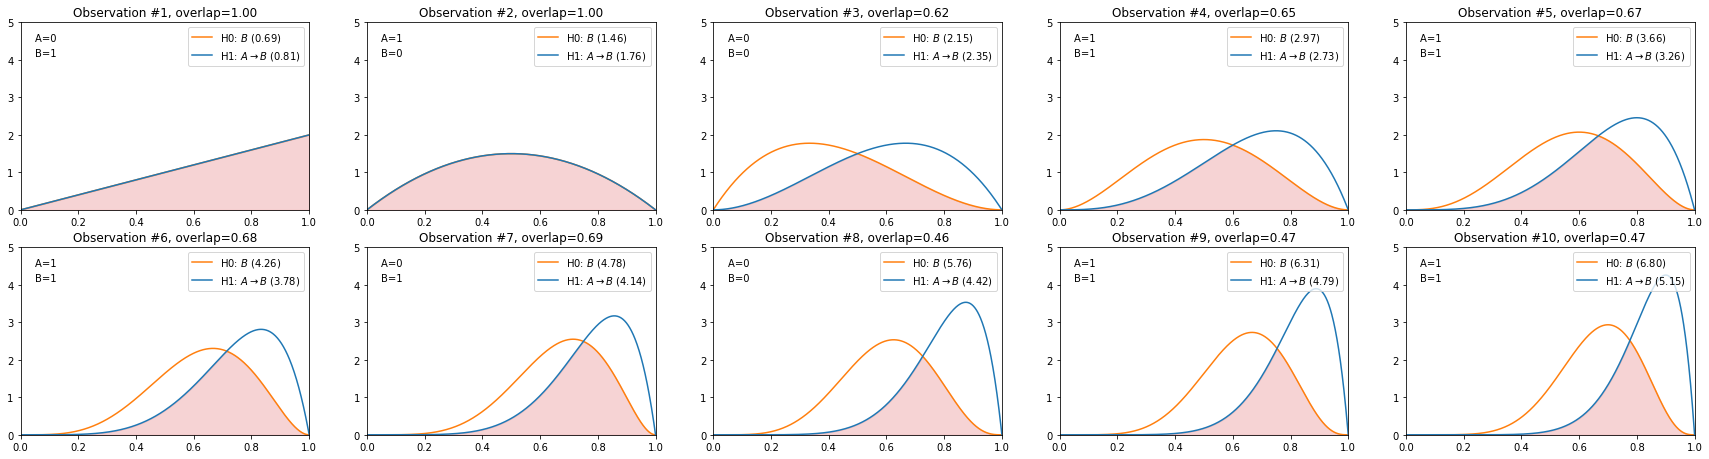

In [31]:
simple_implication(data)

### Baseline

In [32]:
data = ((0,0), (0,0), (0,0), (1,1), (1,1), (1,1), (1,1), (1,1))

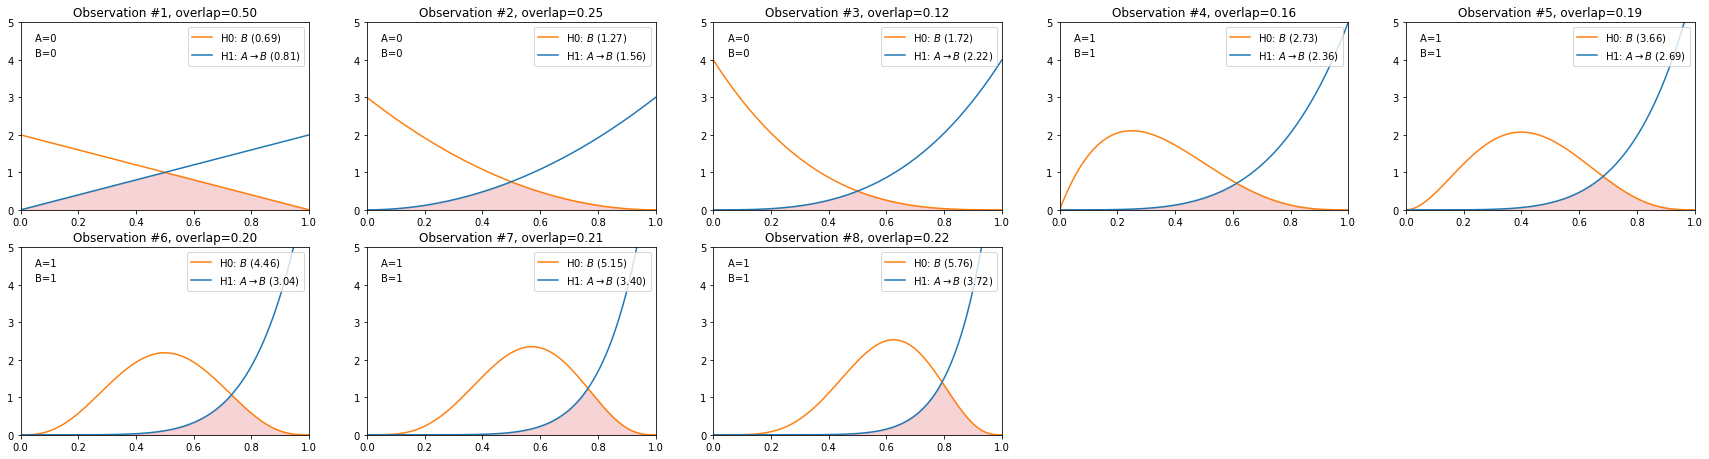

In [33]:
simple_implication(data)

### US preexposure effect (blocage)

In [36]:
# (A,B) observations
data = ((0,1), (0,1), (0,1), (0,1), (0,1), (1,1), (1,1), (1,1), (1,1), (1,1))
#data = ((1,1), (1,1), (1,1), (1,1), (1,1), (1,1), (1,1))

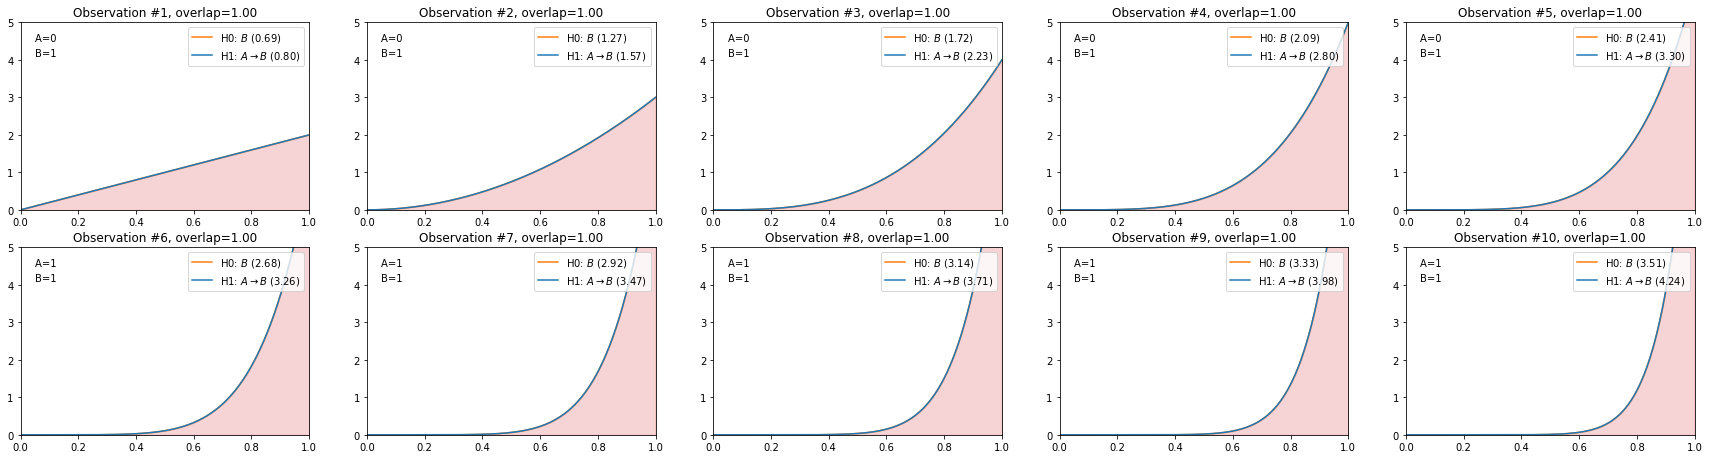

In [37]:
simple_implication(data)

### CS preexposure effect (léger  conditionnement??)

In [38]:
# (A,B) observations
data = ((1,0), (1,0), (1,0), (1,0), (1,0), (1,1), (1,1), (1,1), (1,1), (1,1),)
#data = ((1,1), (1,1), (1,1), (1,1), (1,1), (1,1), (1,1))

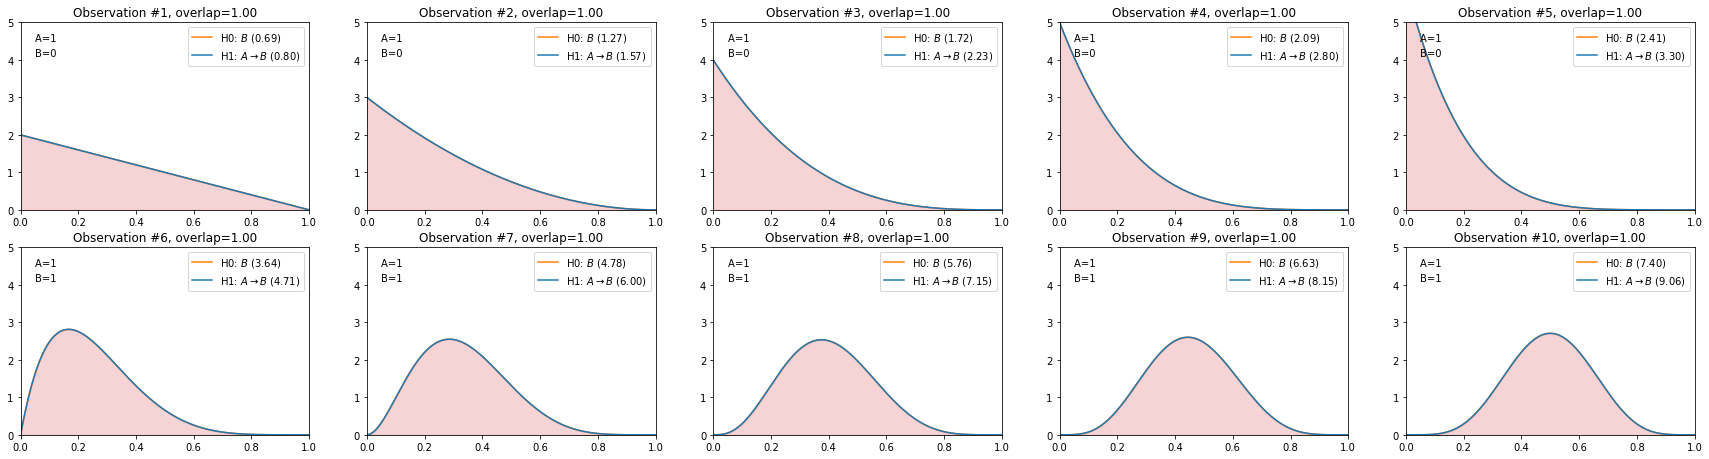

In [39]:
simple_implication(data)

## Cue competition : A, X, --> B

  * H0 : non(A --> B) ou non(X --> B) : (A et non-B) ou (X et non-B)
  * H1 : A --> B et X --> B : (non-A ou B) et (non-X ou B) : (non-A et non-X) ou (non-A et B) ou (B et non-X) ou B   
                                                           : (non-A et non-X) ou B 
  * H0 : (A ou X) --> non-B : non(A ou X) ou non-B : (non-A et non-X) ou non-B
  * H1 : (A ou X) --> B : non(A ou X) ou B : (non-A et non-X) ou B
  * H2 : A --> B : non(A)  ou B 
  * H3 : X --> B : non(X) ou B 
 


In [54]:
def cue_competition_implication(data):
    plt.figure(figsize=(30,20))
    H0 = ((0,0,1), (0,1,1), (1,0,1),(1,1,1))
    H1 = ((0,0,0), (0,1,0), (1,0,0),(1,1,0))
    
    H2 = ((0,0,0), (0,1,0), (0,0,1), (0,1,1),
      (1,0,1), (1,1,1))
    alpha_A_dict = {(0,0): 1, (0,1): 1, (1,0): 1, (1,1): 1}
   
    H3 = ((0,0,0), (1,0,0), (0,0,1), (1,0,1),
      (0,1,1), (1,1,1))
    alpha_X_dict = {(0,0,0): 1, (0,0,1): 1, (0,1,0): 1, (0,1,1): 1,
                    (1,0,0): 1, (1,0,1): 1, (1,1,0): 1, (1,1,1): 1}

    beta_ = {'H0':[1,1], 'H1':[1,1],'H2':[1,1], 'H3':[1,1]}
    log_lik_0 = 0
    log_lik_1 = 0
    log_lik_2 = 0
    log_lik_3 = 0
    for i, obs in enumerate(data):
        ax = plt.subplot(5,5,i+1)
        if obs in H0:
            beta_['H0'][0] += 1
            h0 = 1
        else:
            beta_['H0'][1] += 1
            h0 = 0
        if obs in H1:
            beta_['H1'][0] += 1
            h1 = 1
        else:
            beta_['H1'][1] += 1
            h1 = 0
        if obs in H2:
            beta_['H2'][0] += 1
            h2 = 1
        else:
            beta_['H2'][1] += 1
            h2 = 0
        if obs in H3:
            beta_['H3'][0] += 1
            h3 = 1
        else:
            beta_['H3'][1] += 1
            h3 = 0
        alpha_A_dict[obs[:2]] += 1
        alpha_X_dict[obs] += 1
            
        pdf_H0 = beta.pdf(x, beta_['H0'][0], beta_['H0'][1])
        pdf_H1 = beta.pdf(x, beta_['H1'][0], beta_['H1'][1])
        pdf_H2 = beta.pdf(x, beta_['H2'][0], beta_['H2'][1])
        pdf_H3 = beta.pdf(x, beta_['H3'][0], beta_['H3'][1])
        
        ll, _ = quad(lambda q: log_likelihood(q, h0) * beta.pdf(q, beta_['H0'][0], beta_['H0'][1]), 0, 1) 
        log_lik_0 += ll
        KL_0, _ = quad(lambda q: beta.pdf(q, beta_['H0'][0], beta_['H0'][1]) * np.log(beta.pdf(q, beta_['H0'][0], beta_['H0'][1])/ beta.pdf(q, 1, 1)), 0, 1)
        FE_0 = - log_lik_0 + KL_0
        
        ll, _ = quad(lambda q: log_likelihood(q, h1) * beta.pdf(q, beta_['H1'][0], beta_['H1'][1]), 0, 1) 
        log_lik_1 += ll
        KL_1, _ = quad(lambda q: beta.pdf(q, beta_['H1'][0], beta_['H1'][1]) * np.log(beta.pdf(q, beta_['H1'][0], beta_['H1'][1])/ beta.pdf(q, 1, 1)), 0, 1)
        FE_1 = - log_lik_1 + KL_1
        
        ll, _ = quad(lambda q: log_likelihood(q, h2) * beta.pdf(q, beta_['H2'][0], beta_['H2'][1]), 0, 1) 
        log_lik_2 += ll
        KL_2 = dirichlet_kl_divergence_monte_carlo(list(alpha_A_dict.values()), [1,1,1,1])
        FE_2 = - log_lik_2 + KL_2
        
        ll, _ = quad(lambda q: log_likelihood(q, h3) * beta.pdf(q, beta_['H3'][0], beta_['H3'][1]), 0, 1) 
        log_lik_3 += ll
        KL_3 = dirichlet_kl_divergence_monte_carlo(list(alpha_X_dict.values()), [1,1,1,1,1,1,1,1])
        FE_3 = - log_lik_3 + KL_3
        
        #ax.plot(x, pdf_H0, label=r'H0: $\neg (A \rightarrow B) \vee \neg (X \rightarrow B)$', color='tab:orange')
        #ax.plot(x, pdf_H1, label=r'H1: $A \rightarrow B \wedge X \rightarrow B$', color='tab:blue')
        ax.plot(x, pdf_H0-0.03, label=r'H0: $B$'+f' ({FE_0:.2f})', color='tab:orange')
        #ax.plot(x, pdf_H1, label=r'H1: $\neg B$', color='tab:red')
        ax.plot(x, pdf_H2+0.03, label=r'H2: $A \rightarrow B$'+f' ({FE_2:.2f})', color='tab:green')
        ax.plot(x, pdf_H3+0.06, label=r'H3: $X \rightarrow B$'+f' ({FE_3:.2f})', color='tab:purple')
        overlap_surface_1 = np.minimum(pdf_H0, pdf_H2)
        overlap_surface_2 = np.minimum(pdf_H0, pdf_H3)
        overlap_prob_1 = np.trapz(np.minimum(pdf_H0, pdf_H2), x)
        overlap_prob_2 = np.trapz(np.minimum(pdf_H0, pdf_H3), x)
        ax.fill_between(x, np.zeros_like(overlap_surface_1), overlap_surface_1, color='tab:green', alpha=.2)
        ax.fill_between(x, np.zeros_like(overlap_surface_2), overlap_surface_2, color='tab:purple', alpha=.2)
        ax.set_title(f'#{i+1}, ovl1={overlap_prob_1:.2f}, ovl2={overlap_prob_2:.2f}')
        ax.text(0.05,4.5,f'A={obs[0]}')
        ax.text(0.05,4.1,f'X={obs[1]}')
        ax.text(0.05,3.7,f'B={obs[2]}')
        ax.set_ylim(0,5)
        ax.set_xlim(0,1)
        plt.legend(loc=1)

    

In [48]:
data = ((0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,0,0), (1,0,0), (1,0,0), (1,0,0), (1,0,0))

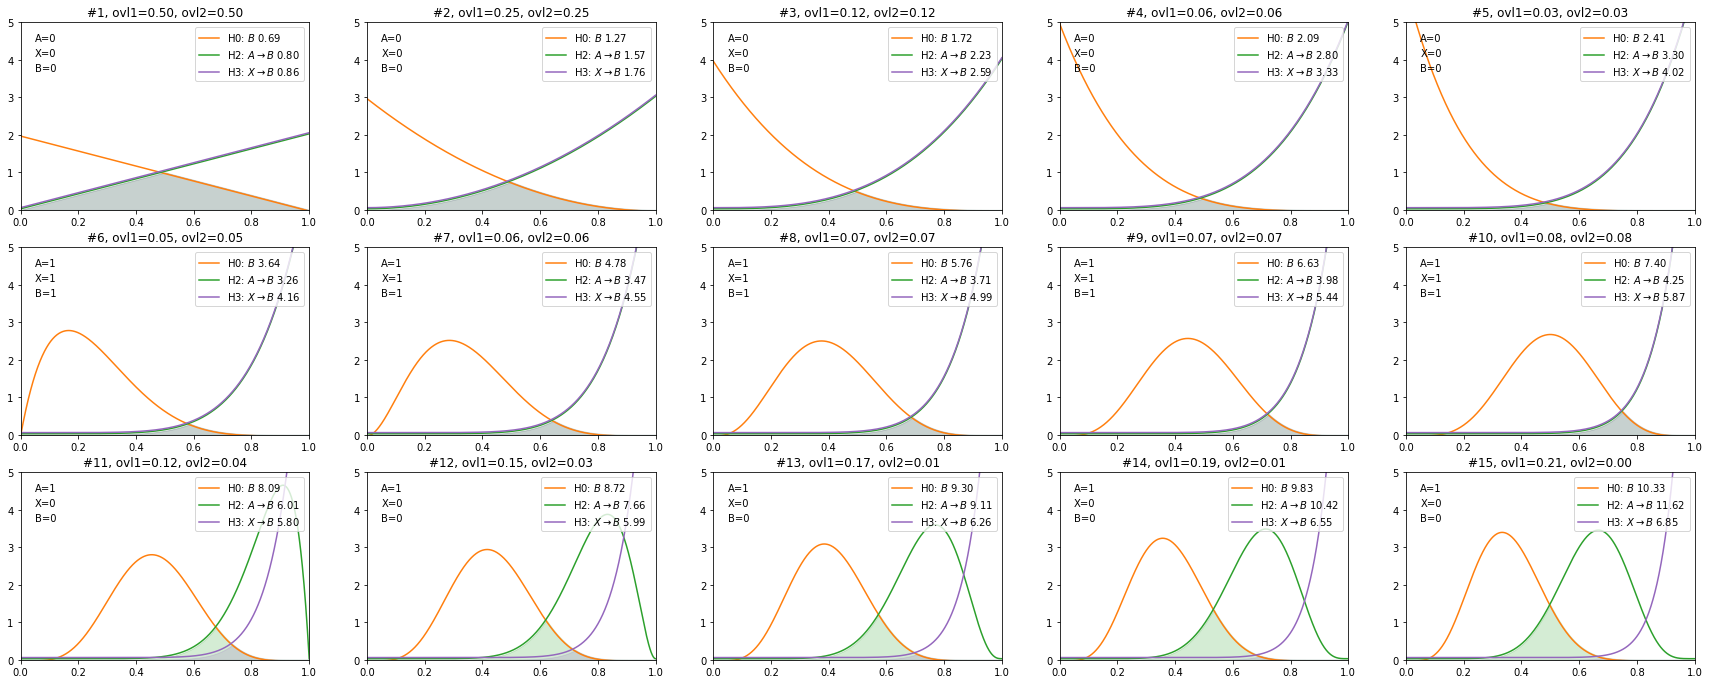

In [49]:
cue_competition_implication(data)

## Blocking

In [55]:
data = ((0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1))

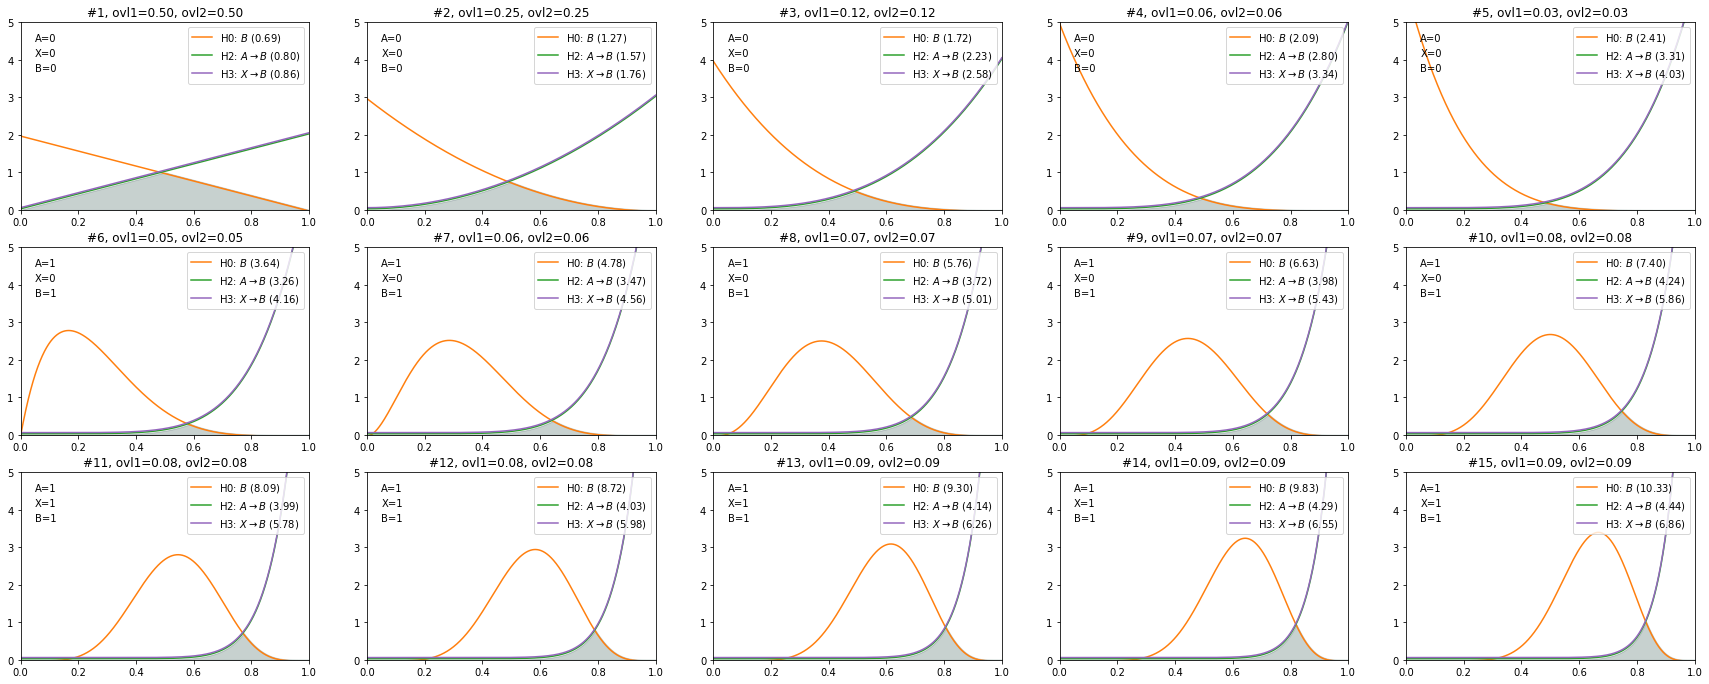

In [56]:
cue_competition_implication(data)

## Retrospective reevaluation : A, X, --> B

In [52]:
data = ((0,0,0), (0,0,0), (0,0,0), (0,0,0), (0,0,0), (1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,0,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,1,1), (1,0,0), (1,0,0), (1,0,0), (1,0,0), (1,0,0))

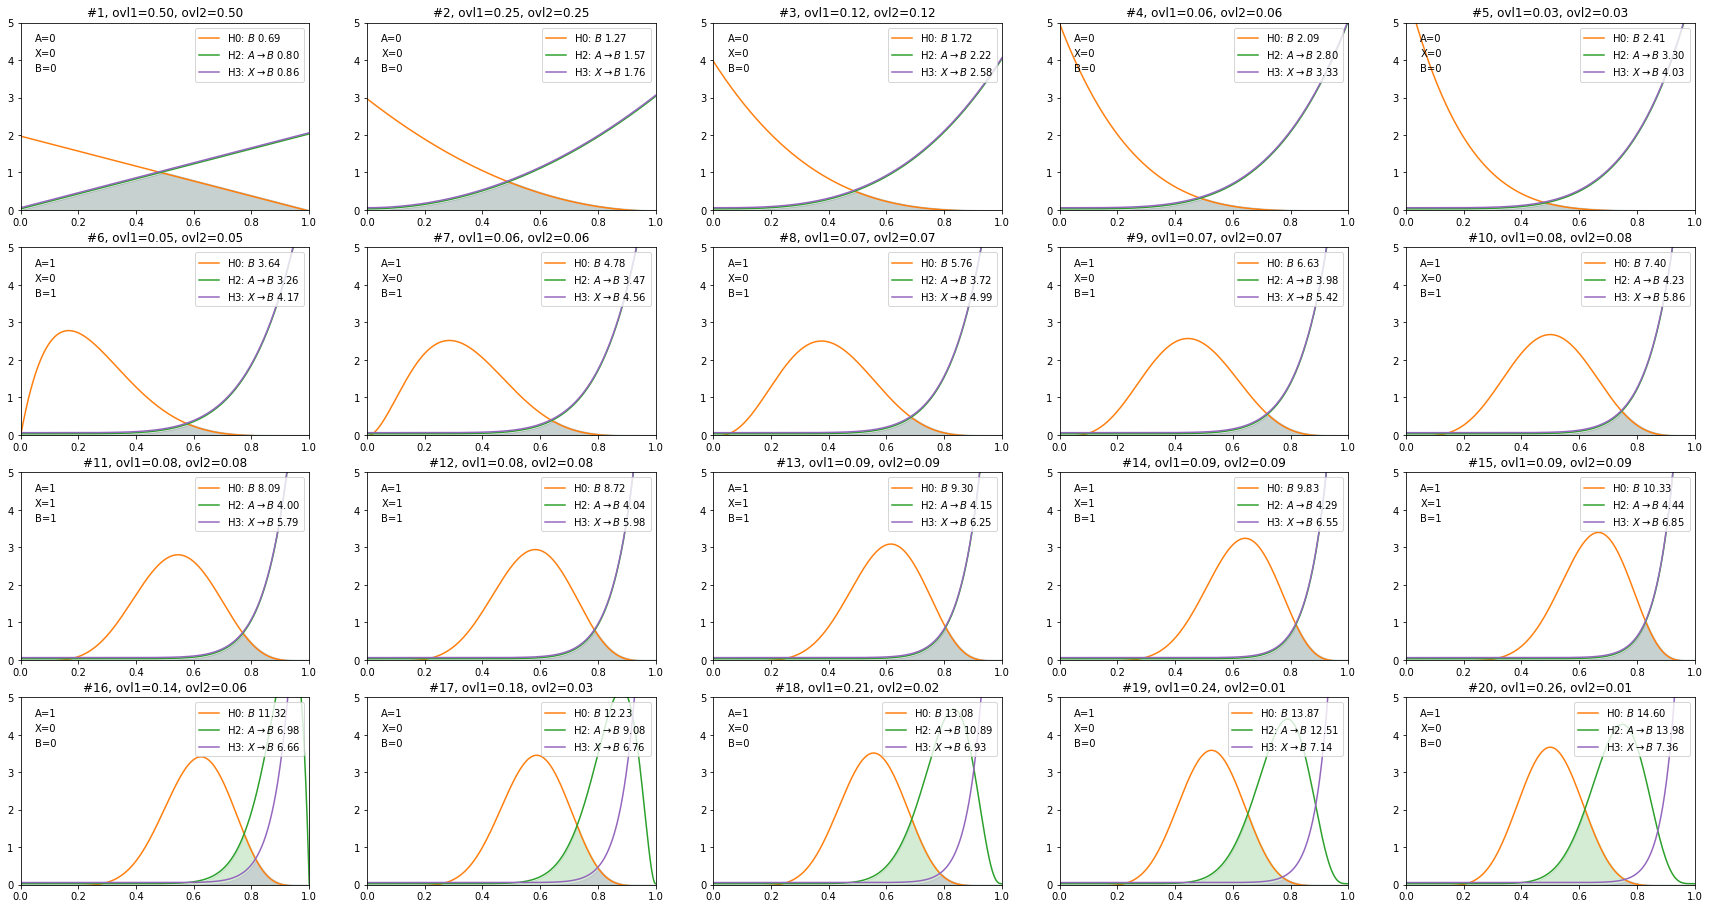

In [53]:
cue_competition_implication(data)

## Modelling contextual effect (Renewal)

H0 = A --> B = non-A ou B 

H1 = C1 --> (A --> B) = C1 --> non-A ou B = non-C1 ou (non-A ou B) 

H2 = C2 --> (A --> non-B) = C2 --> non-A ou non-B = non-C2 ou (non-A ou non-B) 

In [40]:
def contextual_effect_implication(data):
    plt.figure(figsize=(30,20))
    H0 = ((0,0,0,0), (0,0,0,1), (0,0,1,1),
      (0,1,0,0), (0,1,0,1), (0,1,1,1),
      (1,0,0,0), (1,0,0,1), (1,0,1,1),
      (1,1,0,0), (1,1,0,1), (1,1,1,1),)
    #H0 = ((1,0)) #non : A --> B
    H1 = ((0,0,0,0), (0,0,0,1), (0,0,1,0), (0,0,1,1),
          (0,1,0,0), (0,1,0,1), (0,1,1,0), (0,1,1,1),
          (1,0,0,0), (1,0,0,1), (1,0,1,1),
          (1,1,0,0), (1,1,0,1), (1,1,1,1))
    H2 = ((0,0,0,0), (0,0,0,1), (0,0,1,0), (0,0,1,0),
          (1,0,0,0), (1,0,0,1), (1,0,1,0), (1,0,1,1),
          (0,1,0,0), (0,1,0,1), (0,1,1,0),
          (1,1,0,0), (1,1,0,1), (1,1,1,0))
    beta_ = {'H0':[1,1], 'H1':[1,1], 'H2':[1,1]}
    for i, obs in enumerate(data):
        ax = plt.subplot(5,5,i+1)
        if obs in H0:
            beta_['H0'][0] += 1
        else:
            beta_['H0'][1] += 1
        if obs in H1:
            beta_['H1'][0] += 1
        else:
            beta_['H1'][1] += 1
        if obs in H2:
            beta_['H2'][0] += 1
        else:
            beta_['H2'][1] += 1
        
        pdf_H0 = beta.pdf(x, beta_['H0'][0], beta_['H0'][1])
        pdf_H1 = beta.pdf(x, beta_['H1'][0], beta_['H1'][1])
        pdf_H2 = beta.pdf(x, beta_['H2'][0], beta_['H2'][1])
        #ax.plot(x, pdf_H0, label=r'H0: $\neg (A \rightarrow B) \vee \neg (X \rightarrow B)$', color='tab:orange')
        #ax.plot(x, pdf_H1, label=r'H1: $A \rightarrow B \wedge X \rightarrow B$', color='tab:blue')
        ax.plot(x, pdf_H0, label=r'H0: $A \rightarrow B$', color='tab:orange')
        ax.plot(x, pdf_H1+0.03, label=r'H1: $C1 \rightarrow (A \rightarrow B)$', color='tab:red')
        ax.plot(x, pdf_H2+0.06, label=r'H2: $C2 \rightarrow (A \rightarrow \neg B)$', color='tab:green')
        overlap_surface_1 = np.minimum(pdf_H0, pdf_H1)
        overlap_surface_2 = np.minimum(pdf_H0, pdf_H2)
        overlap_prob_1 = np.trapz(np.minimum(pdf_H0, pdf_H1), x)
        overlap_prob_2 = np.trapz(np.minimum(pdf_H0, pdf_H2), x)
        ax.fill_between(x, np.zeros_like(overlap_surface_1), overlap_surface_1, color='tab:green', alpha=.2)
        ax.fill_between(x, np.zeros_like(overlap_surface_2), overlap_surface_2, color='tab:purple', alpha=.2)
        ax.set_title(f'#{i+1}, ovl1={overlap_prob_1:.2f}, ovl2={overlap_prob_2:.2f}')
        ax.text(0.05,4.5,f'C1={obs[0]}')
        ax.text(0.05,4.1,f'C2={obs[1]}')
        ax.text(0.05,3.7,f'A={obs[2]}')
        ax.text(0.05,3.3,f'B={obs[3]}')
        ax.set_ylim(0,5)
        ax.set_xlim(0,1)
        plt.legend(loc=1)


In [41]:
# (C1, C2, A, B) observations
data = ((1,0,1,1), (1,0,1,1), (1,0,1,1), (1,0,1,1), (1,0,1,1), (0,1,1,0), (0,1,1,0), (0,1,1,0), (0,1,1,0), (0,1,1,0))
#data = ((1,1), (1,1), (1,1), (1,1), (1,1), (1,1), (1,1))

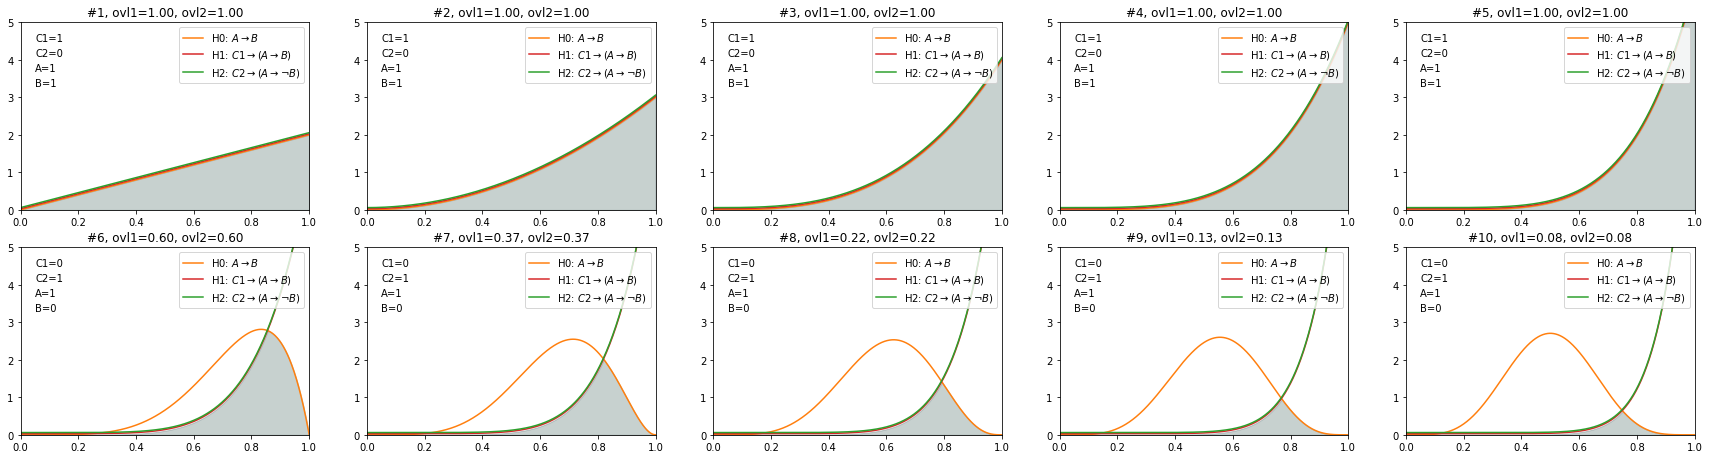

In [42]:
contextual_effect_implication(data)